In [18]:
import os, json
# from typing_extensions import Literal
from typing import Literal
from typing import List, Dict
from collections import Counter

def save_json(data, path):
    with open(path, "w") as f:
        json.dump(data, f, indent =4)

def load_json(path, default = None):
    if not os.path.exists(path):
        if default == None:
            raise ValueError(f"The '{path}' path does not exist")
        return default

    with open(path) as f:
        data = json.load(f)
    return data



def decide_by_frequency(face_labels: List[Dict]):
    all_features = {k for o in face_labels for k in list(o.keys())}

    decided = {}
    for feature in all_features:
        labels = [o.get(feature) for o in face_labels]
        most_common = Counter(filter(lambda x: x in ("Yes", "No", "Undef"), labels)).most_common()

        # most_common = [('Yes', 2), ('No', 1)]
        if len(most_common) == 0:
            continue
        elif len(most_common) == 1:
            decided[feature] = most_common[0][0]
        else:
            # Check if the experts are disagreeing
            if most_common[0][1] > most_common[1][1]:
                decided[feature] = most_common[0][0]
    return decided


def decide_on_labels(original_labels):
    grouped_labels = {}

    #group by image_name
    for obj in original_labels:
        image_name = obj["image_name"]
        grouped_labels[image_name] = grouped_labels.get(image_name, []) + [obj]

    decided_labels = {}
    for image_name, multilabels in grouped_labels.items():
        decided_labels[image_name] = {
            "image_name": image_name,
            "bounding_boxes": multilabels[0]["bounding_boxes"],
            "face_labels": decide_by_frequency([el["face_labels"] for el in multilabels])
        }

    return decided_labels



In [4]:
labels = load_json("ImageLabels.json")
decided = decide_on_labels(labels)



In [5]:
old_decided = load_json("DecidedLabels.json", {}, )


In [10]:
from deepdiff import DeepDiff

diff = DeepDiff(old_decided, decided, ignore_order=True)


In [17]:
added = diff.get("dictionary_item_added")

added[0]





"root['in_001382_male_21_InGlasses0.jpg']"

In [19]:
i = 0
n = {}
for k, v in decided.items():
    n[k] = v
    i += 1
    if i == 3:
        break
save_json(n, "t.json")

In [42]:
obj = {
    "img1.jpg": {
        "image_name": "in_001382_male_21_InGlasses0.jpg",
        "bounding_boxes": {
            "Mouth_Whole": {
                "top_left": {
                    "x": 1174,
                    "y": 3038
                },
                "bottom_right": {
                    "x": 2153,
                    "y": 3629
                }
            }
        },
        "face_labels": {
            "EyeLeft_Lower_Tearsack": "Yes",
            "CheekLeft_Whole_Red": "No",
            "MouthRight_Corner_Red": "No",
            "EyeLeft_UpperLid_Droopy": "No",
            "MouthUpper_UnderLip_VerticalWrinkles": "No",
            "EyeRight_Lower_Pale": "No",
            "MouthRight_Corner_Cracked": "No",
            "EyeLeft_Whole_Protruding": "No",
            "EyeRight_Lower_Tearsack": "No"
        }
    }
}

from deepdiff import DeepDiff
from copy import deepcopy
from deepdiff.helper import NotPresent



In [51]:
def new_feature(path):
    image_name = path[0]
    feature_name = path[-1]
    print("New feature")
    print(f"\t image_name = {image_name}")
    print(f"\t feature_name = {feature_name}")
    print()

def modified_feature(path):
    print("Modified feature")

def modified_bounding_box(path):
    print("Modified bounding box")

def added_bounding_box(path):
    print("Added bounding box")

def changes_analyser(diff):
    for change_type, list_of_changes in diff.items():
        for change in list_of_changes:
            #dictionary_item_added
            path = change.path(output_format="list")

            if path[1] == "face_labels":
                if change_type == "dictionary_item_added":
                    new_feature(path)
                elif change_type == "values_changed":
                    modified_feature(path)
            elif path[1] == "bounding_boxes":
                if change_type == "dictionary_item_added":
                    added_bounding_box(path)
                elif change_type == "values_changed":
                    modified_bounding_box(path)
            else:
                raise Exception("Object change was not caught")


objs1 = deepcopy(obj)
objs2 = deepcopy(obj)

new_bb = {
    "top_left": {
        "x": 1174,
        "y": 3038
    },
    "bottom_right": {
        "x": 2153,
        "y": 3629
    }
}

# Add feature
objs2["img1.jpg"]["face_labels"]["EyesCrossed"] = "Yes"
# Modify feature
objs2["img1.jpg"]["face_labels"]["CheekLeft_Whole_Red"] = "Yes"
# Add bounding box
objs2["img1.jpg"]["bounding_boxes"]["Mouth_Partial"] = new_bb
# Modify bounding box
objs2["img1.jpg"]["bounding_boxes"]["Mouth_Whole"]["top_left"]["x"] = 2000
del objs2["img1.jpg"]["face_labels"]["MouthRight_Corner_Cracked"]
diff = DeepDiff(objs1, objs2, view="tree")
changes_analyser(diff)



Added bounding box
New feature
	 image_name = img1.jpg
	 feature_name = EyesCrossed
Modified bounding box
Modified feature


bounding_boxes dictionary_item_added
	Old: not present
	new: {'top_left': {'x': 1174, 'y': 3038}, 'bottom_right': {'x': 2153, 'y': 3629}}
face_labels dictionary_item_added
True
	Old: not present
	new: Yes
face_labels dictionary_item_removed
False
	Old: No
	new: not present
bounding_boxes values_changed
	Old: 1174
	new: 2000
face_labels values_changed
False
	Old: No
	new: Yes


Types of changes:

1) Added label for feature
    We need to find the parameters:
        1) image name
        2) bounding box value for the feature
        3) value(Yes, No)

        Pass all the parameters to a function that will:
            a) Crop the original image
            b) Rotate and crop other images

2) Modified label for feature
    Yes, No, Undef => Remove from old, if old = [Yes or No] and add to new if new = [Yes or No]

3) Modified bounding box
    We need to find the parameters:
        1) bounding_box name
        2) model name that corresponds to the bounding box
        3) image_name
        3) feature_name

        Pass all the parameters to a function that will:
            a) Remove old cropped images(original and rotated)
            b) Crop again and add to the model folders for all models that use this bounding box

<!-- 4) Added bounding box
    We need to find the parameters:
        1) bounding_box name
        2) model name that corresponds to the bounding box
        3) image_name
        3) feature_name

        Pass all the parameters to a function that will:
            a) Remove old cropped images(original and rotated)
            b) Crop again and add to the model folders for all models that use this bounding box -->



In [6]:
change = diff["dictionary_item_added"][0]

In [9]:
change.all_down

<root['img1.jpg']['face_labels']['new_bb'] t1:not present, t2:'Yes'>

In [21]:
path = change.path(output_format="list")

if path[1] == "face_labels":
    print("FaceLabels", f"old: {}", end="")
elif path[1] == "bounding_boxes":
    print("BoundingBoxes", end="")


['img1.jpg', 'face_labels', 'new_bb']

In [27]:
a = diff["dictionary_item_added"][0]

In [30]:
a.up.t1



{'EyeLeft_Lower_Tearsack': 'Yes',
 'CheekLeft_Whole_Red': 'No',
 'MouthRight_Corner_Red': 'No',
 'EyeLeft_UpperLid_Droopy': 'No',
 'MouthUpper_UnderLip_VerticalWrinkles': 'No',
 'EyeRight_Lower_Pale': 'No',
 'MouthRight_Corner_Cracked': 'No',
 'EyeLeft_Whole_Protruding': 'No',
 'EyeRight_Lower_Tearsack': 'No'}

In [42]:
old_decided


{}

In [39]:
len(decided),len(labels)


(4782, 5232)

ModuleNotFoundError: No module named 'deepdiff'

[('a', 2), ('b', 1)]

In [27]:
count_frequency(
[
{
            "EyeLeft_NasalRoot_Dark": "Yes",
            "EyeRight_NasalRoot_Dark": "No",
            "EyeLeft_OuterCorner_Dark": "No",
            "EyeRight_OuterCorner_Dark": "No",
            "EyeLeft_InnerCorner_BrightDot": "No",
            "EyeRight_InnerCorner_BrightDot": "No",
            "EyeLeft_InnerCorner_Bright": "No",
        },
{
            "EyeLeft_NasalRoot_Dark": "Yes",
            "EyeRight_NasalRoot_Dark": "No",
            "EyeLeft_OuterCorner_Dark": "No",
        },
{
            "EyeLeft_NasalRoot_Dark": "No",
            "EyeRight_NasalRoot_Dark": "No",
            "EyeLeft_OuterCorner_Dark": "No",
        },
]

)

{'EyeLeft_InnerCorner_Bright': 'No',
 'EyeLeft_OuterCorner_Dark': 'No',
 'EyeRight_InnerCorner_BrightDot': 'No',
 'EyeLeft_NasalRoot_Dark': 'Yes',
 'EyeRight_OuterCorner_Dark': 'No',
 'EyeLeft_InnerCorner_BrightDot': 'No',
 'EyeRight_NasalRoot_Dark': 'No'}

In [9]:
decided


{'1b1dcbfe-741d-4dac-ad39-c8bbf46f55de_ACQ.png': [{'bounding_boxes': {'Mouth_Whole': {'top_left': {'x': 778,
      'y': 1860},
     'bottom_right': {'x': 1332, 'y': 2107}},
    'ForeheadCenter_Lower': {'top_left': {'x': 927, 'y': 833},
     'bottom_right': {'x': 1154, 'y': 1351}},
    'EyeLeft_Whole': {'top_left': {'x': 626, 'y': 1100},
     'bottom_right': {'x': 921, 'y': 1365}},
    'EyeRight_Whole': {'top_left': {'x': 1172, 'y': 1064},
     'bottom_right': {'x': 1488, 'y': 1355}},
    'EyeLeft_InnerCorner': {'top_left': {'x': 852, 'y': 1178},
     'bottom_right': {'x': 961, 'y': 1323}},
    'EyeRight_InnerCorner': {'top_left': {'x': 1130, 'y': 1158},
     'bottom_right': {'x': 1248, 'y': 1313}},
    'EyeLeft_OuterCorner': {'top_left': {'x': 576, 'y': 1168},
     'bottom_right': {'x': 658, 'y': 1332}},
    'EyeRight_OuterCorner': {'top_left': {'x': 1440, 'y': 1152},
     'bottom_right': {'x': 1548, 'y': 1324}},
    'EyeLeft_NasalRoot': {'top_left': {'x': 932, 'y': 1235},
     'bottom

In [7]:


unique_features = set()

for r in all_labels:
  unique_features.update(list(r["face_labels"].keys()))

model_to_feature = {}

for f in unique_features:
  u = f.replace("Right", "").replace("Left", "")

  if u not in model_to_feature:
    model_to_feature[u] = [f]
  else:
    model_to_feature[u].append(f)

model_to_feature

NameError: name 'all_labels' is not defined

In [ ]:
from utils.label_validator import ImageLabel

def validate_labels(image_labels):
  return [ImageLabel(**lb) for lb in image_labels]

In [ ]:
all_images = set([l.image_name for l in all_labels])

feature_to_model = {v: k for k, values in model_to_feature.items() for v in values}
feature_to_bb = {f: "_".join(f.split("_")[:-1]) for f in  feature_to_model.keys()}

In [ ]:
from utils.constants import INFO_PATH, IMAGES_PATH

In [ ]:
# with open(INFO_PATH, "w") as f:
#   # data = json.load(f)
#   data = {}
#   data["FEATURE_TO_MODEL"] = feature_to_model
#   data["FEATURE_TO_BOUNDING_BOX"] = feature_to_bb,
#   data["LABELED_IMAGES"] = list(all_images)
#   data["MODELS_TO_FEATURES"] = model_to_feature
#   json.dump(data,f, indent=4)

In [ ]:
with open(INFO_PATH) as f:
  data = json.load(f)

In [ ]:
all_images = data["LABELED_IMAGES"]

In [ ]:

downloaded = os.listdir(IMAGES_PATH)

missing = [img for img in all_images if img not in downloaded]

len(missing)

46

In [ ]:
len(missing_batch) * 50

3150

In [ ]:
import requests

def download_image(url: str, save_path: str):
  req = requests.get(url)
  req.raise_for_status()

  with open(save_path, "wb") as f:
    f.write(req.content)

In [ ]:
all_labels = validate_labels(all_labels)

In [ ]:
!rm utils.zip
!zip utils.zip utils -r

  adding: utils/ (stored 0%)
  adding: utils/__pycache__/ (stored 0%)
  adding: utils/__pycache__/helper_func.cpython-37.pyc (deflated 41%)
  adding: utils/__pycache__/cropping.cpython-37.pyc (deflated 40%)
  adding: utils/__pycache__/label_validator.cpython-37.pyc (deflated 54%)
  adding: utils/__pycache__/__init__.cpython-37.pyc (deflated 26%)
  adding: utils/__pycache__/constants.cpython-37.pyc (deflated 33%)
  adding: utils/helper_func.py (deflated 61%)
  adding: utils/local_config.json (deflated 26%)
  adding: utils/label_validator.py (deflated 72%)
  adding: utils/.ipynb_checkpoints/ (stored 0%)
  adding: utils/__init__.py (stored 0%)
  adding: utils/constants.py (deflated 54%)
  adding: utils/cropping.py (deflated 67%)


In [ ]:
# Save data in different folders for different models
# Each object has this format:
# {
#   "image_name": "in_001382_male_21_InGlasses0.jpg",
#   "bounding_box": {
#     "top_left": {
#       "x": 1482,
#       "y": 3654
#     },
#     "bottom_right": {
#       "x": 1864,
#       "y": 3748
#     }
#   }
# }

import os, json
from utils.constants import PROCESSED_LABELS_PATH

original_data = {model_name: {"Yes": {}, "No":{}} for model_name in model_to_feature.keys()}

for label in all_labels:

  for feature, value in label.face_labels.items():
    model_name = feature_to_model[feature]
    if value in ("Yes", "No"):
      bb_name = feature_to_bb[feature]

      side = ""
      if "Left" in feature:
        side = "Left"
      elif "Right" in feature:
        side = "Right"

      bb = label.bounding_boxes.get(bb_name)
      if not bb or bb == "NotValid":
        continue
      img_name = label.image_name
      obj = {
          "image_name": img_name,
          "bounding_box": bb.dict(),
      }
      if side:
        obj["side"] = side
      original_data[model_name][value][img_name] = obj

for model_name, labels in original_data.items():
  
  for label, objects in labels.items():
    
    path = os.path.join(PROCESSED_LABELS_PATH, model_name)
    os.makedirs(path, exist_ok=True)
    
    obj_path = os.path.join(path, f"{label}.json")

    with open(obj_path, "w") as f:
      json.dump(objects, f, indent=4)

In [44]:
from deepdiff import DeepDiff  # For Deep Difference of 2 objects
from deepdiff import grep, DeepSearch  # For finding if item exists in an object
from deepdiff import DeepHash

In [49]:
a = {
    "img1": {
      "l1": "yes", 
      "l2": "no"         
    },
    "goodbye": 2
}

b = {
    "img1": {
      "l1": "no", 
      "l2": "no"         
    },
    "goodbye": 2,
     "bye": 4
}

DeepDiff(a, b)



{'dictionary_item_added': [root['bye']],
 'values_changed': {"root['img1']['l1']": {'new_value': 'no',
   'old_value': 'yes'}}}

In [50]:
DeepHash(a)

{'img1': 'a191948d6e97acfcb38bbdd51a2fbf55095b3be2baa84155807e9cc52d042bfe', 'l1': '352e72d3c622ec3954ae096d7da368be4979a3d68668134be2858b4084c987da', 'yes': '37b1eedf69826c9ade65e48f4baba79bd781b80141e9221167fc3ea69afbd949', 'l2': '27ee189cc347dcee00a819723b834cd1e4d3a2a86b539173840fafd49b612f73', 'no': '199f849c0f1be94281c4f2ce6333fd910e0e516be4ce13d48131560165ff76a6', '!>*id140589510484768': '539246fc6be378594a99448372e4086bca741404b3427870005a5c674ff9c1f8', 'goodbye': '29f089a8994e5d0f93a...}

In [ ]:
!rm CroppedAugmented CroppedOriginal -r

In [ ]:
from utils.cropping import crop_images

#17 minutes
model_name = "Eye_OuterCorner_Dark"

crop_images(model_name)

328it [01:07,  4.87it/s]
2889it [15:31,  3.10it/s]


['06804_NVDE.jpg',
 'bionary_labeling_evafeuchter_wtcvlxqeii_acq.jpeg',
 '43200_NVDE.jpg',
 '23760_NVDE.jpg',
 '16875_NVDE.jpg',
 '36457_NVDE.jpg',
 '09583_NVDE.jpg',
 'bionary_labeling_evafeuchter_0m4rogo3d2_acq.jpeg',
 '16257_NVDE.jpg',
 '35657_NVDE.jpg',
 'bionary_labeling_evafeuchter_ekyo11ev8z_acq.jpeg',
 'bionary_labeling_evafeuchter_zus0rubi8u_acq.jpeg',
 '14356_NVDE.jpg',
 '06804_NVDE.jpg',
 'bionary_labeling_evafeuchter_88n98wqhyl_acq.jpeg',
 '27968_NVDE.jpg',
 'bionary_labeling_evafeuchter_lvi06ny05n_acq.jpeg',
 '43197_NVDE.jpg',
 'bionary_labeling_evafeuchter_27bo7haxnz_acq.jpeg',
 'bionary_labeling_evafeuchter_bbsawi4ce5_acq.jpeg',
 '39361_NVDE.jpg',
 '17489_NVDE.jpg']

In [ ]:

from utils.cropping import count_widths_heights

In [ ]:
model_name = "Eye_OuterCorner_Dark"

res = count_widths_heights(model_name)

widths = res["widths"]
heights = res["heights"]

3195it [00:01, 2415.13it/s] 


In [40]:
import concurrent
from PIL import Image
from utils.constants import CROPPED_RESIZED_PATH, CROPPED_ORIG_PATH
from typing import Tuple, Dict
from tqdm import tqdm
import os
import numpy as np

def read_numpy(src_img_path, size_w_h = Tuple[int, int]):
  return np.array(Image.open(src_img_path))
# Counts the amount of 
def read_images_as_ndarray(model_name: str, size_w_h = Tuple[int, int], max_workers = 100)-> Dict[str, np.ndarray]:
  width, height = size_w_h
  source_model_path = os.path.join(CROPPED_RESIZED_PATH, model_name, f"w_{width}_h_{height}")

  if not os.path.exists(source_model_path):
    raise ValueError(f"Path '{source_model_path}' does not exist")

  data = {}
  for label in ("Yes", "No"):

    source_folder = os.path.join(source_model_path, label)
    images_to_read = [os.path.join(source_folder, img) for img in os.listdir(source_folder) if ".png" in img]
    

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
      futures = []

      for img_path in images_to_read:
        futures.append( executor.submit(read_numpy, img_path))
      data[label] = [future.result() for future in tqdm(concurrent.futures.as_completed(futures))]

  for k in data:
    data[k] = np.array(data[k])
  return data


In [ ]:
model_name = "Eye_OuterCorner_Dark"
data = read_images_as_ndarray(model_name, (125, 200))

In [42]:
import deepdiff

ModuleNotFoundError: ignored

In [39]:
for k, v in data.items():
  print(k, v.shape)

Yes (327, 200, 125, 3)
No (2868, 200, 125, 3)


In [35]:
data["Yes"] = np.array(data["Yes"])

In [36]:
data["Yes"].shape

(327, 200, 125, 3)

In [27]:
model_name = "Eye_OuterCorner_Dark"
resize_images_for_model(model_name, (125, 200))

3195it [00:47, 67.23it/s]


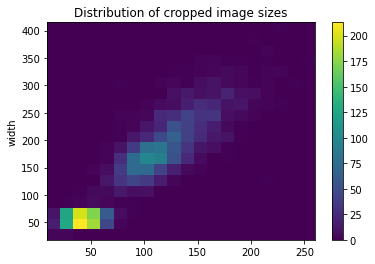

In [ ]:
draw_histogram(widths, heights)

In [ ]:
json_path = "/content/LabelsProcessed/Eye_OuterCorner_Dark/No.json"

with open(json_path) as f:
  objects = json.load(f)

a = [k for k in list(objects.keys())]
print(len(a))

json_path = "/content/LabelsProcessed/Eye_OuterCorner_Dark/Yes.json"

with open(json_path) as f:
  objects = json.load(f)

a = [k for k in list(objects.keys())]
print(len(a))

2889
328


In [41]:
!zip utils.zip utils -r

updating: utils/ (stored 0%)
updating: utils/__pycache__/ (stored 0%)
updating: utils/__pycache__/helper_func.cpython-37.pyc (deflated 41%)
updating: utils/__pycache__/cropping.cpython-37.pyc (deflated 40%)
updating: utils/__pycache__/label_validator.cpython-37.pyc (deflated 54%)
updating: utils/__pycache__/__init__.cpython-37.pyc (deflated 26%)
updating: utils/__pycache__/constants.cpython-37.pyc (deflated 33%)
updating: utils/helper_func.py (deflated 61%)
updating: utils/local_config.json (deflated 26%)
updating: utils/label_validator.py (deflated 72%)
updating: utils/.ipynb_checkpoints/ (stored 0%)
updating: utils/__init__.py (stored 0%)
updating: utils/constants.py (deflated 54%)
updating: utils/cropping.py (deflated 70%)
